<a href="https://colab.research.google.com/github/kjamison/krakencoder/blob/main/krakencoder_example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Krakencoder usage example

This notebook provides an example of how to load connectome data and apply a pretrained Krakencoder model to that data.

The process is as follows:
1.   Load model
2.   Load new data and do mild domain adaptation (map input data mean to training data mean)
3.   Transform each input data flavor into 128-dimensional latent space
4.   Average latent space across all types ("fusion") or across only SC data ("fusionSC")
  * Note: this might be used for prediction, clustering, etc.
5.   Transform "fusion" averaged latent vectors to output connectomes

For more information, visit [github.com/kjamison/krakencoder](https://github.com/kjamison/krakencoder)

In [1]:
#clone repo and add to path
!git clone https://github.com/kjamison/krakencoder.git
import sys
if not '/content/krakencoder' in sys.path:
  sys.path.append('/content/krakencoder')

Cloning into 'krakencoder'...
remote: Enumerating objects: 516, done.
remote: Counting objects: 100% (240/240), done.
remote: Compressing objects: 100% (160/160), done.
remote: Total 516 (delta 147), reused 166 (delta 79), pack-reused 276 (from 1)
Receiving objects: 100% (516/516), 18.25 MiB | 14.17 MiB/s, done.
Resolving deltas: 100% (325/325), done.


In [2]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

from krakencoder.model import Krakencoder
from krakencoder.adaptermodel import KrakenAdapter
from krakencoder.utils import square2tri, tri2square, numpyvar
from krakencoder.data import generate_adapt_transformer, load_transformers_from_file
from krakencoder.fetch import fetch_model_data
from krakencoder import loss

import krakencoder.jupyter_functions as kjf

In [3]:
# load model checkpoint and precomputed PCA transforms
# The first time these are used, they are downloaded to package_dir/model_data (~1.3GB)
# To use an alternate storage location, you can set the KRAKENCODER_DATA environment variable
checkpoint_file=fetch_model_data('kraken_chkpt_SCFC_fs86+shen268+coco439_pc256_225paths_latent128_20240413_ep002000.pt')

ioxfm_file_list=fetch_model_data(['kraken_ioxfm_SCFC_fs86_pc256_710train.npy',
                 'kraken_ioxfm_SCFC_shen268_pc256_710train.npy',
                 'kraken_ioxfm_SCFC_coco439_pc256_710train.npy'])

inner_net, checkpoint_info = Krakencoder.load_checkpoint(checkpoint_file, eval_mode=True)
transformer_list, transformer_info_list = load_transformers_from_file(ioxfm_file_list)

#create new model that wraps the inner kraken model and includes PCA transforms from raw data
net=KrakenAdapter(inner_model=inner_net,
                  data_transformer_list=[transformer_list[conntype] for conntype in checkpoint_info['input_name_list']],
                  linear_polynomial_order=0,
                  eval_mode=True)

100%|██████████| 4.07M/4.07M [00:00<00:00, 73.0MB/s]


100%|██████████| 37.6M/37.6M [00:00<00:00, 74.1MB/s]


100%|██████████| 368M/368M [00:04<00:00, 75.9MB/s]


100%|██████████| 988M/988M [00:17<00:00, 56.8MB/s]
/content/krakencoder/krakencoder/model.py:473: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint=torch.load(filenam

Loading precomputed input transformations: /content/cache/krakencoder/model_data/kraken_ioxfm_SCFC_fs86_pc256_710train.npy
Loading precomputed input transformations: /content/cache/krakencoder/model_data/kraken_ioxfm_SCFC_shen268_pc256_710train.npy
Loading precomputed input transformations: /content/cache/krakencoder/model_data/kraken_ioxfm_SCFC_coco439_pc256_710train.npy


# Load connectivity data files
* Data should be a BIDS(ish) .zip file with a set of ROIxROI .tsv files for each connectome
* File must contain a `participants_info.tsv` with a row for each subject, including BIDS `participant_id`, etc...
* Each tsv file should be `sub-<subject>_atlas-<atlas>_meas-<flavor>_relmat.dense.tsv`
    * where `<atlas>` could be `fs86`, `shen268`, `coco439`, etc...
    * and `<flavor>` could be `FCcorrHPF`, `FCcorrHPFGSR`, `FCpcorrHPF`, `SCsdstreamVN`, `SCifod2actVN`, etc...

In [4]:
# @title Load data (GUI)

conndata_squaremats = None
participants_info = None

kjf.jupyter_create_upload_widget(
    loadfile_callback=lambda filename, filebytes=None, allowed_extensions=None: kjf.callback_load_and_process_data(
        filename,
        filebytes,
        allowed_extensions,
        variablename_loaddata="conndata_squaremats",
        variablename_participants="participants_info",
        globals_set=globals()
    ),
    extensions=[".zip", ".mat"],
    multiple=False,
    initial_tab="local",
    initial_local_path=".",
)

Output()

In [5]:
# @title Load data (backup)

if conndata_squaremats is None:
    # in case we use "Run All" and it tries to run the next cell before the data is loaded
    kjf.callback_load_and_process_data(
        os.path.abspath("./krakencoder/example_data/example_bidsdir_5flav_20subj.zip"),
        variablename_loaddata="conndata_squaremats",
        variablename_participants="participants_info",
        globals_set=globals(),
    )

Loading data from /content/krakencoder/example_data/example_bidsdir_5flav_20subj.zip
Loaded data into 'conndata_squaremats' and 'participants_info'
participants_info contains 20 subjects
  20/20 subjects are designated as 'training' for domain adaptation
input type SCifod2act_fs86_volnorm has 20 [86x86] matrices
input type SCsdstream_fs86_volnorm has 20 [86x86] matrices
input type FCcorr_fs86_hpf has 20 [86x86] matrices
input type FCcorr_fs86_hpfgsr has 20 [86x86] matrices
input type FCpcorr_fs86_hpf has 20 [86x86] matrices


In [6]:
#input data are lists of [roi x roi] square matrices so convert those to [subj x edges]

#skip internal header keys
conntypes=[c for c in conndata_squaremats.keys() if not c.startswith("_")]

conndata={}
conndata_triidx={} #store so we can restore square later
for c in conntypes:
    conndata[c]={'data': np.stack([square2tri(x) for x in conndata_squaremats[c]])}
    _, conndata_triidx[c]=square2tri(conndata_squaremats[c][0],return_indices=True)
    print("conndata_squaremats['%s']=%s" % (c,kjf.data_shape_string(conndata_squaremats[c])),end='')
    print(" -> conndata['%s']['data']=%s" % (c,kjf.data_shape_string(conndata[c]['data'])))

conndata_squaremats['SCifod2act_fs86_volnorm']=20x[86x86] -> conndata['SCifod2act_fs86_volnorm']['data']=20x3655
conndata_squaremats['SCsdstream_fs86_volnorm']=20x[86x86] -> conndata['SCsdstream_fs86_volnorm']['data']=20x3655
conndata_squaremats['FCcorr_fs86_hpf']=20x[86x86] -> conndata['FCcorr_fs86_hpf']['data']=20x3655
conndata_squaremats['FCcorr_fs86_hpfgsr']=20x[86x86] -> conndata['FCcorr_fs86_hpfgsr']['data']=20x3655
conndata_squaremats['FCpcorr_fs86_hpf']=20x[86x86] -> conndata['FCpcorr_fs86_hpf']['data']=20x3655


# Transform input data to Krakencoder latent space
 * First adapt mean of each flavor to training population mean
 * Then apply Krakencoder to transform into latent space

In [7]:
# @title Adapt input data to match training data
# compute SIMPLE domain adaptation transform: map mean(input subjects) to mean(training subjects) for each flavor
# and transform each input data flavor to match training data mean
#
# It's not really needed for these data since they are from HCP-YA already, which the model was trained on.
# That is why the model fits are all roughly "y = 1.0*x + 0". It is shown here for demonstration purposes only.
adxfm_dict={}
conndata_adapted={}
for c in conndata:
  print("Adapting %s" % (c))
  adxfm_dict[c]=generate_adapt_transformer(input_data=conndata[c]['data'],
                                           target_data=transformer_info_list[c],
                                           adapt_mode='meanfit+meanshift')
  conndata_adapted[c]={'data':adxfm_dict[c].transform(conndata[c]['data'])}

Adapting SCifod2act_fs86_volnorm
	Fitting input data mean to transformer mean: modeldata=inputdata*1.004 + 0.003
	Input data mean for adapt has 20 subjects.
	Adapted fit R2: 0.995
Adapting SCsdstream_fs86_volnorm
	Fitting input data mean to transformer mean: modeldata=inputdata*1.017 + 0.001
	Input data mean for adapt has 20 subjects.
	Adapted fit R2: 0.995
Adapting FCcorr_fs86_hpf
	Fitting input data mean to transformer mean: modeldata=inputdata*0.926 + 0.009
	Input data mean for adapt has 20 subjects.
	Adapted fit R2: 0.979
Adapting FCcorr_fs86_hpfgsr
	Fitting input data mean to transformer mean: modeldata=inputdata*0.924 + -0.001
	Input data mean for adapt has 20 subjects.
	Adapted fit R2: 0.981
Adapting FCpcorr_fs86_hpf
	Fitting input data mean to transformer mean: modeldata=inputdata*0.963 + 0.000
	Input data mean for adapt has 20 subjects.
	Adapted fit R2: 0.978


In [8]:
# @title Transform adapted data to Krakencoder latent space
encoded_data={}

#loop through all of the input names from the saved checkpoint,
# because the encoder/decoder indices are in this order.
for encidx, c in enumerate(checkpoint_info['input_name_list']):
  if not c in conndata_adapted:
    #if this input type was not in the example data, skip it
    continue
  with torch.no_grad():
    encoded_data[c]=net(conndata_adapted[c]['data'],encoder_index=encidx, decoder_index=-1)

# compute average latent representation across SC input types
fusion_type='fusionSC'

if fusion_type=='fusion':
  encoded_fusion=torch.mean(torch.stack([encoded_data[c] for c in encoded_data]),axis=0)
elif fusion_type=='fusionSC':
  encoded_fusion=torch.mean(torch.stack([encoded_data[c] for c in encoded_data if c.startswith('SC')]),axis=0)

print("%s latent space representation: " % (fusion_type), kjf.data_shape_string(encoded_fusion))

# Now predict output connectomes from fusion latent representation
# Predictions are stored in predicted_alltypes[inputtype][outputtype]
predicted_alltypes={fusion_type:{}}

for decidx, c in enumerate(checkpoint_info['input_name_list']):
  with torch.no_grad():
    _,pred=net(encoded_fusion,encoder_index=-1, decoder_index=decidx)
  predicted_alltypes[fusion_type][c]=numpyvar(pred) #convert back to numpy for analysis
  print("predicted_alltypes['%s']['%s']: " % (fusion_type,c), kjf.data_shape_string(predicted_alltypes[fusion_type][c]))

#add fusion latent representation to output
predicted_alltypes[fusion_type]['encoded']=numpyvar(encoded_fusion)
print("predicted_alltypes['%s']['%s']: " % (fusion_type,'encoded'), kjf.data_shape_string(predicted_alltypes[fusion_type]['encoded']))

fusionSC latent space representation:  torch[20x128]
predicted_alltypes['fusionSC']['SCifod2act_fs86_volnorm']:  20x3655
predicted_alltypes['fusionSC']['SCsdstream_fs86_volnorm']:  20x3655
predicted_alltypes['fusionSC']['FCcorr_fs86_hpf']:  20x3655
predicted_alltypes['fusionSC']['FCcorr_fs86_hpfgsr']:  20x3655
predicted_alltypes['fusionSC']['FCpcorr_fs86_hpf']:  20x3655
predicted_alltypes['fusionSC']['SCifod2act_shen268_volnorm']:  20x35778
predicted_alltypes['fusionSC']['SCsdstream_shen268_volnorm']:  20x35778
predicted_alltypes['fusionSC']['FCcorr_shen268_hpf']:  20x35778
predicted_alltypes['fusionSC']['FCcorr_shen268_hpfgsr']:  20x35778
predicted_alltypes['fusionSC']['FCpcorr_shen268_hpf']:  20x35778
predicted_alltypes['fusionSC']['SCifod2act_coco439_volnorm']:  20x96141
predicted_alltypes['fusionSC']['SCsdstream_coco439_volnorm']:  20x96141
predicted_alltypes['fusionSC']['FCcorr_coco439_hpf']:  20x96141
predicted_alltypes['fusionSC']['FCcorr_coco439_hpfgsr']:  20x96141
predicted_al

# Quick visualization of an observed and predicted connectivity matrix

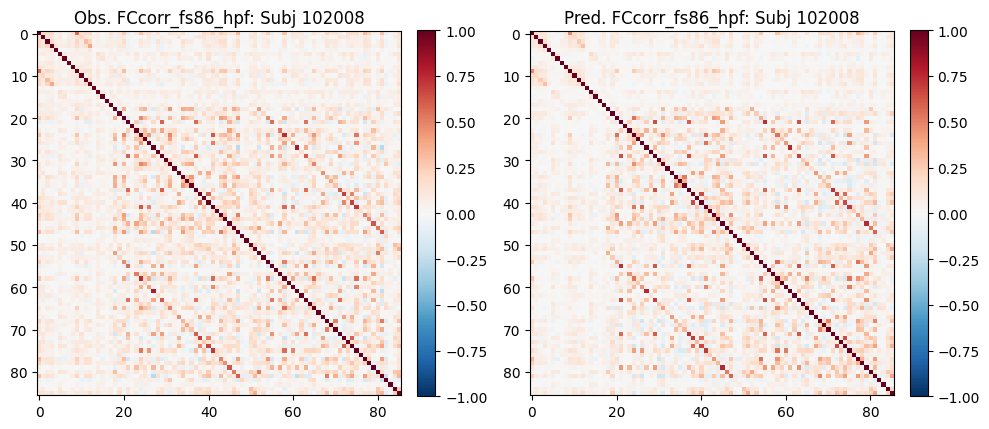

In [9]:
# convert upper tri back to square to display observed and predicted connectomes

conntype='FCcorr_fs86_hpf'

isubj=0

Cobs_square=tri2square(conndata_adapted[conntype]['data'][isubj,:],
                            tri_indices=conndata_triidx[conntype],
                            diagval=1) #diagval=1 for FC
Cpred_square=tri2square(predicted_alltypes[fusion_type][conntype][isubj,:],
                            tri_indices=conndata_triidx[conntype],
                            diagval=1) #diagval=1 for FC

#make sure these are converted back to CPU/numpy before trying to display
Cobs_square=numpyvar(Cobs_square)
Cpred_square=numpyvar(Cpred_square)

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
im=plt.imshow(Cobs_square, vmin=-1, vmax=1, cmap='RdBu_r')
plt.colorbar(im,fraction=0.046, pad=.04)
plt.title('Obs. %s: Subj %s' % (conntype,participants_info.iloc[isubj]['subject']))

plt.subplot(1,2,2)
im=plt.imshow(Cpred_square, vmin=-1, vmax=1, cmap='RdBu_r')
plt.colorbar(im,fraction=0.046, pad=0.04)
plt.title('Pred. %s: Subj %s' % (conntype,participants_info.iloc[isubj]['subject']))

plt.tight_layout()
plt.show()

# Demonstration of prediction identifiability
* For each flavor, we look at (SUBJECT)x(SUBJECT) correlations after removing population mean for
    1. Observed vs Observed (measured connectome variability)
    2. Predicted vs Predicted (predicted connetome variability)
    3. Observed vs Predicted (prediction accuracy)
* For Observed vs Predicted, we show the rank for each observed connectome (row) against the set of all predicted connectomes
    * For a perfectly identifiable set of predictions, the rank would be 1 for every row
    * "Average Rank Percentile" is the average of these ranks, expressed as a percentile (1.0=perfect, 0.5=chance)

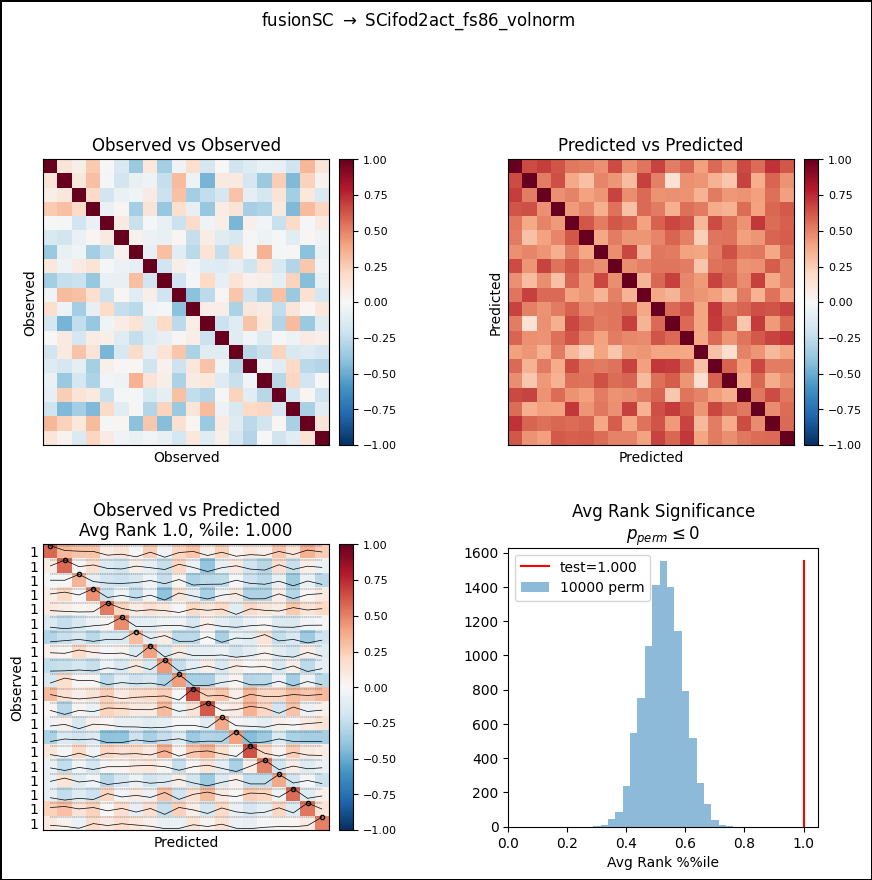

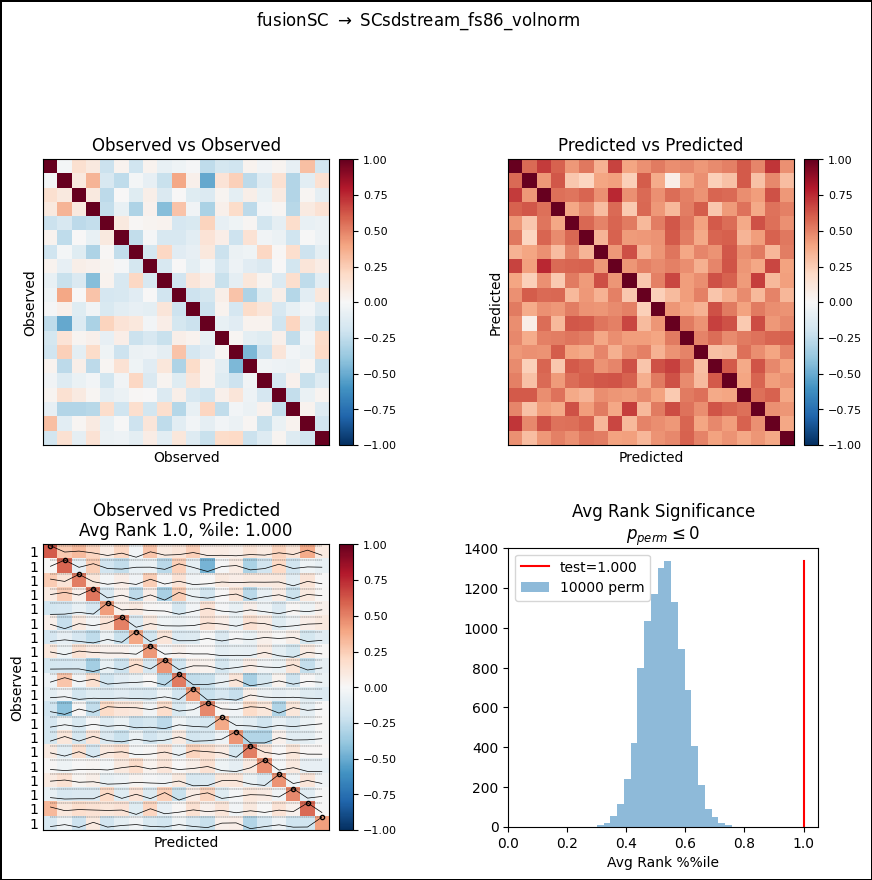

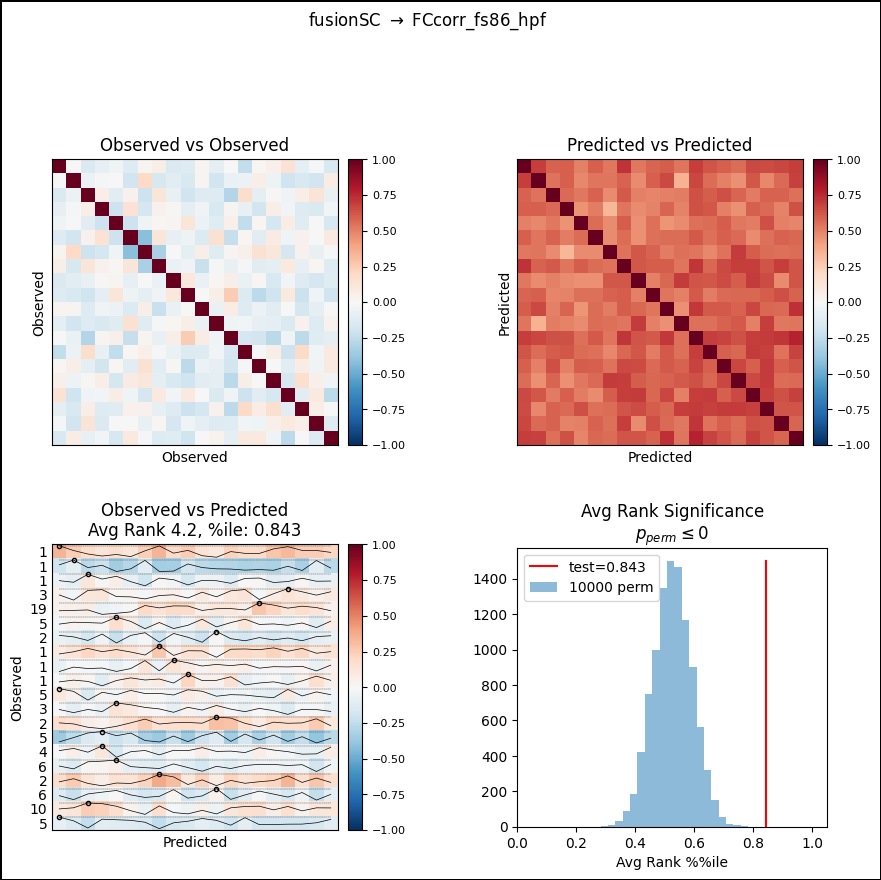

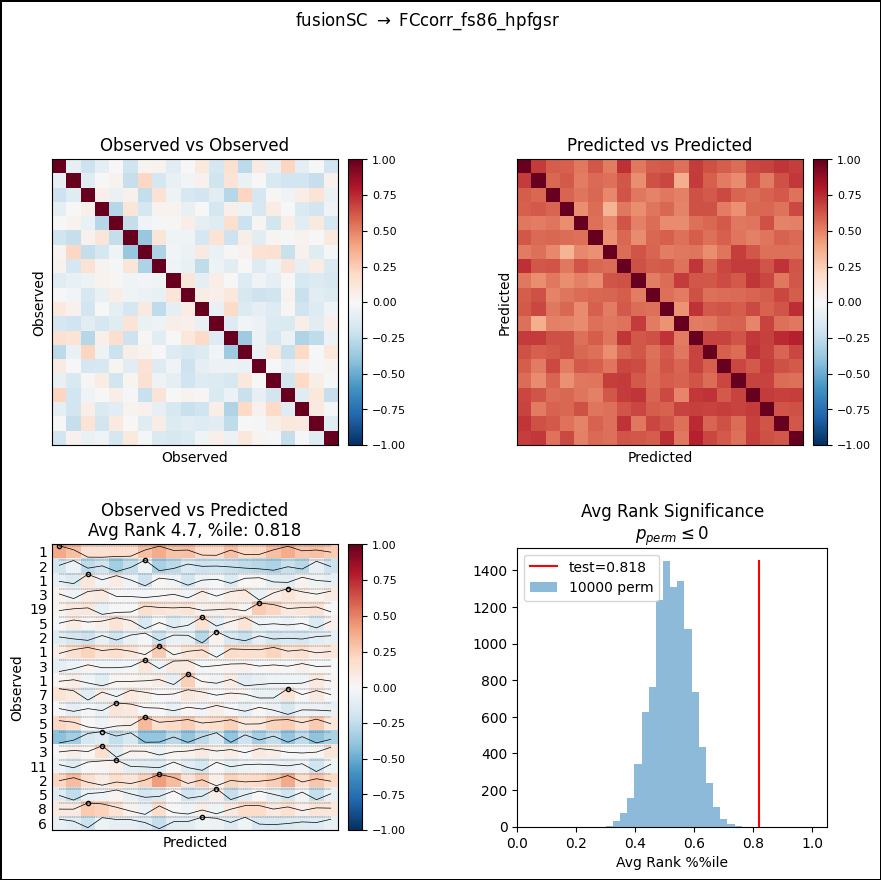

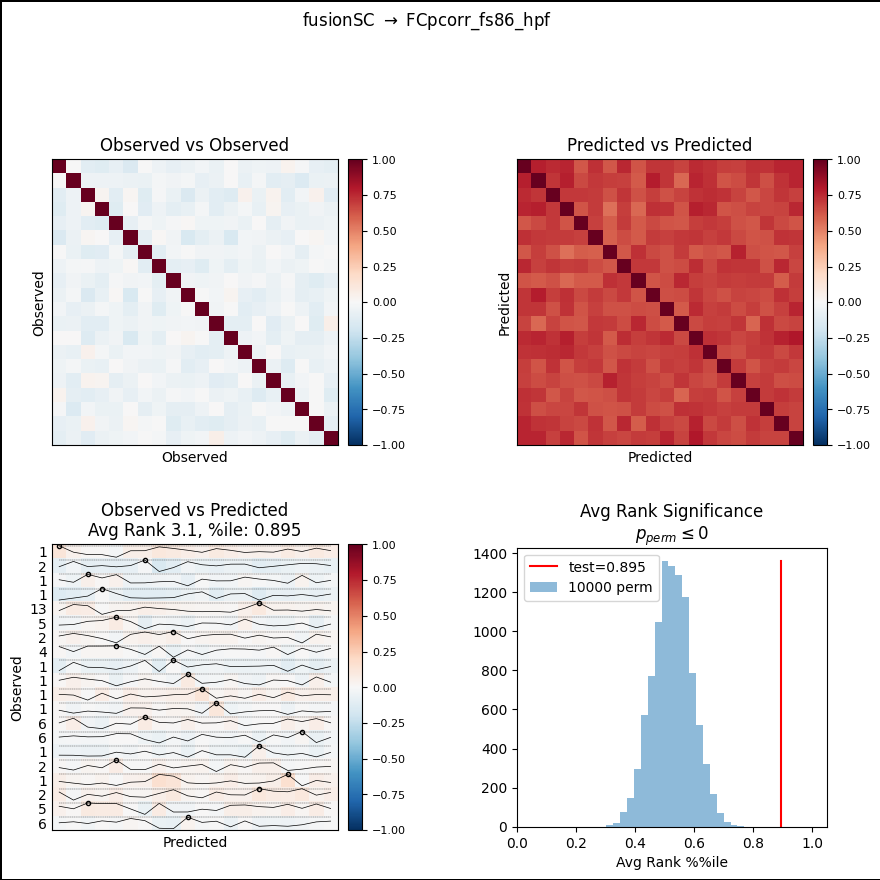

In [10]:
prediction_input=fusion_type

nperm=10000
#nperm=100 #for quick testing

for conntype in conntypes:
    Xobs=conndata[conntype]['data']
    Xpred=predicted_alltypes[prediction_input][conntype]

    Xobs_mean=np.mean(Xobs,axis=0)

    # Remove the group mean before computing similarity
    Xobs=Xobs-Xobs_mean
    Xpred=Xpred-Xobs_mean

    fig, axs = plt.subplots(nrows=2,ncols=2,figsize=(10,10))
    axs=axs.flatten()

    for iax, (x1, x2, group1, group2) in enumerate(
        [
            [Xobs, Xobs, "Observed", "Observed"],
            [Xpred, Xpred, "Predicted", "Predicted"],
            [Xobs, Xpred, "Observed", "Predicted"],
        ]
    ):
        sim=loss.xycorr(x1,x2)
        avgrank=loss.corravgrank(cc=sim)

        ax=axs[iax]
        im=ax.imshow(sim, vmin=-1,vmax=1,cmap='RdBu_r')
        # im=ax.imshow(sim, cmap='RdBu_r')

        ax.set_xticks([])
        ax.set_yticks([])

        groupxy=[group2,group1]
        titlestr='%s vs %s' % (groupxy[1],groupxy[0])

        if [group1,group2]==["Observed", "Predicted"]:
            #for Observed vs Predicted, display lines and rank for each observation
            ranklist=[]
            for i in range(sim.shape[0]):
                cci=sim[i,:] #get row for this observation
                cci=(cci-np.nanmin(cci))/(np.nanmax(cci)-np.nanmin(cci)) #scale row from 0-1
                cci=(cci-.5)*.8 #scale for display

                cci_maxidx=np.argmax(cci)
                cci_sortidx=np.argsort(np.argsort(cci)[::-1])
                ax.plot(np.arange(len(cci)),i-cci,color='k',linewidth=.5)
                ax.plot([0,len(cci)-1],[i-cci[cci_maxidx], i-cci[cci_maxidx]],'k--',linewidth=.25)
                ax.plot(cci_maxidx,i-cci[cci_maxidx],'k.',markerfacecolor='none')
                ranklist.append(cci_sortidx[i]+1)

            avgrank_index=np.mean(ranklist)
            titlestr+='\n'+'Avg Rank %.1f, %%ile: %.3f' % (avgrank_index,avgrank)
            ax.set_yticks(np.arange(sim.shape[0]))
            ax.set_yticklabels(['%d' % (r) for r in ranklist])
            ax.tick_params(axis='y',length=0)

        ax.set_title(titlestr)
        ax.set_xlabel(groupxy[0])
        ax.set_ylabel(groupxy[1])

        #add colorbar that is the same height as the plot
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=0.1)
        cbar = fig.colorbar(im, cax=cax)
        cbar.ax.tick_params(labelsize=8)


    #plot permutation test histogram for avgrank
    ax=axs[-1]

    avgrank_obs2pred_perm = [
        loss.corravgrank(
            cc=loss.xycorr(Xobs, Xpred[np.random.permutation(Xpred.shape[0]), :])
        )
        for i in range(nperm)
    ]

    p_perm=np.mean(avgrank<avgrank_obs2pred_perm)
    xh=ax.hist(avgrank_obs2pred_perm,bins=20,alpha=.5)
    ax.plot([avgrank,avgrank],[0,max(xh[0])],'-r')
    ax.legend(['test=%.3f' % (avgrank),'%d perm' % (nperm)])
    ax.set_xlim([0,1.05])
    ax.set_aspect(aspect=.9*np.diff(ax.get_xlim())/np.diff(ax.get_ylim()))
    ax.set_xlabel('Avg Rank %%ile')
    ax.set_title('Avg Rank Significance\n$p_{perm}\leq$%g' % (p_perm))

    fig.subplots_adjust(wspace=.5,hspace=0)

    fig.suptitle(r'%s $\rightarrow$ %s' % (prediction_input,conntype))
    fig.patch.set_linewidth(1)
    fig.patch.set_edgecolor('k')

    plt.show()

In [11]:
# @title Convert predicted connectomes back to square matrices

predicted_square={}
for conntype in conntypes:
    if conntype == 'encoded':
        continue
    diagval = 1 if conntype.startswith("FC") else 0

    predicted_square[conntype] = [
        tri2square(
            predicted_alltypes[fusion_type][conntype][i, :],
            tri_indices=conndata_triidx[conntype],
            diagval=diagval,
        )
        for i in range(predicted_alltypes[fusion_type][conntype].shape[0])
    ]
    print("predicted_alltypes['%s']['%s']=%s" % (fusion_type,conntype,kjf.data_shape_string(predicted_alltypes[fusion_type][conntype])),end='')
    print(" -> predicted_square['%s']=%s" % (conntype,kjf.data_shape_string(predicted_square[conntype])))

predicted_alltypes['fusionSC']['SCifod2act_fs86_volnorm']=20x3655 -> predicted_square['SCifod2act_fs86_volnorm']=20x[86x86]
predicted_alltypes['fusionSC']['SCsdstream_fs86_volnorm']=20x3655 -> predicted_square['SCsdstream_fs86_volnorm']=20x[86x86]
predicted_alltypes['fusionSC']['FCcorr_fs86_hpf']=20x3655 -> predicted_square['FCcorr_fs86_hpf']=20x[86x86]
predicted_alltypes['fusionSC']['FCcorr_fs86_hpfgsr']=20x3655 -> predicted_square['FCcorr_fs86_hpfgsr']=20x[86x86]
predicted_alltypes['fusionSC']['FCpcorr_fs86_hpf']=20x3655 -> predicted_square['FCpcorr_fs86_hpf']=20x[86x86]


# Save predicted connectomes to a new BIDS(ish) .zip

In [12]:
# @title Save data zip (GUI)

numflav = len(predicted_square)
numsubj = len(predicted_square[conntypes[0]])

outfile_default = "output_bidsdir_%skraken_%dflav_%dsubj.zip" % (
    fusion_type,
    numflav,
    numsubj,
)

kjf.jupyter_create_save_widget(
    savefile_callback=lambda variablename, filename: kjf.callback_saveoutput(
        variablename,
        filename,
        bids_desc=fusion_type + "kraken",
        variablename_participants="participants_info",
        globals_set=globals()
    ),
    outvariable_default="predicted_square",
    outfile_default=outfile_default,
)

Output()